# BeerBo Printing - Statistical Analysis Jupyter Notebook

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns
from IPython.display import display
from scipy.stats import pearsonr

In [2]:
dev_prop = pd.read_csv("DeviceProperty.csv")
prod_metric = pd.read_csv("ProductionMetric.csv")
quality = pd.read_csv("Quality.csv")

In [3]:
conn = sqlite3.connect(":memory:")
dev_prop.to_sql("DeviceProperty", conn, index=False, if_exists='replace')
prod_metric.to_sql("ProductionMetric", conn, index=False, if_exists='replace')
quality.to_sql("Quality", conn, index=False, if_exists='replace')

7170

## Join: ProductionMetric with DeviceProperty

In [4]:
query1 = """
SELECT 
    pm.*, 
    dp.Area, dp.DefaultCycleTime, dp.Enterprise, dp.Line, 
    dp.Location, dp.Operation, dp.Plant, dp.SubType, dp.Type
FROM ProductionMetric pm
LEFT JOIN DeviceProperty dp
ON pm.deviceKey = dp.deviceKey;
"""
dev_prod = pd.read_sql_query(query1, conn)
dev_prod.head()

,prodmetric_stream_key,deviceKey,start_time,end_time,good_count,reject_count,ideal_time,run_time,unplanned_stop_time,planned_stop_time,...,team_display_name,Area,DefaultCycleTime,Enterprise,Line,Location,Operation,Plant,SubType,Type
0,5552062,Line3,2025-01-29 19:10:14.3284760 -06:00,2025-01-29 19:13:19.6285480 -06:00,0,0,0.000000,0.000000,185.300072,0.0,...,Team 2,Paint-Auto,100,ManuCorp,PaintingMain,Building D-2,Electrostatic Paint,WestPlant,E-Coat,Production-Finish
1,5552060,Line3,2025-01-29 19:05:37.3369440 -06:00,2025-01-29 19:10:14.3284760 -06:00,96,0,157.363822,276.991532,0.000000,0.0,...,Team 2,Paint-Auto,100,ManuCorp,PaintingMain,Building D-2,Electrostatic Paint,WestPlant,E-Coat,Production-Finish
2,5552046,Line4,2025-01-29 19:00:00.0000000 -06:00,2025-01-29 19:02:07.0000000 -06:00,54,0,0.000000,0.000000,0.000000,0.0,...,Team 3,Smart-Logistics,20,ManuCorp,MaterialFlow,Building J,AGV Transfer,WestPlant,Automated,Smart-Logistics
3,5552048,Line2,2025-01-29 19:00:00.0000000 -06:00,2025-01-29 19:01:34.0000000 -06:00,0,0,0.000000,0.000000,0.000000,0.0,...,Team 3,Fab-Pro,75,ManuCorp,WeldingPrimary,Building C-2,Laser Welding,SouthPlant,Precision,Production-Laser
4,5552049,Line1,2025-01-29 19:00:00.0000000 -06:00,2025-01-29 19:01:52.0000000 -06:00,67,0,0.000000,0.000000,0.000000,0.0,...,Team 2,Assembly-2,50,ManuCorp,AssemblyMain,Building G,Advanced Assembly,NorthPlant,HighSpeed,Production-Premium


## Join: Quality with ProductionMetric

In [5]:
query2 = """
SELECT 
    q.*, 
    pm.deviceKey, 
    pm.start_time, pm.end_time, pm.good_count, pm.reject_count, 
    pm.unplanned_stop_time, pm.run_time
FROM Quality q
LEFT JOIN ProductionMetric pm
ON q.prodmetric_stream_key = pm.prodmetric_stream_key;
"""
qual_prod = pd.read_sql_query(query2, conn)
qual_prod.head()

,quality_stream_key,deviceKey,count,reject_reason_display_name,prodmetric_stream_key,deviceKey,start_time,end_time,good_count,reject_count,unplanned_stop_time,run_time
0,1771948,Line 4,6,Detected by Max WIP,5468380,Line4,2025-01-20 11:25:18.4230500 -06:00,2025-01-20 11:35:17.0000000 -06:00,372,6,0.0,598.576950
1,1772152,Line 4,11,Reject,5468383,Line4,2025-01-20 11:39:22.7197510 -06:00,2025-01-20 12:00:00.0000000 -06:00,738,20,0.0,1237.280249
2,1772153,Line 4,9,Detected by Max WIP,5468383,Line4,2025-01-20 11:39:22.7197510 -06:00,2025-01-20 12:00:00.0000000 -06:00,738,20,0.0,1237.280249
3,1772154,Line 4,11,Detected by Max WIP,5468386,Line4,2025-01-20 12:03:49.6202580 -06:00,2025-01-20 12:26:21.3499470 -06:00,806,20,0.0,1351.729689
4,1772155,Line 4,9,Reject,5468386,Line4,2025-01-20 12:03:49.6202580 -06:00,2025-01-20 12:26:21.3499470 -06:00,806,20,0.0,1351.729689


## Total Unplanned vs Planned Stop Time

In [6]:
query3 = """
SELECT 
    SUM(unplanned_stop_time) AS total_unplanned,
    SUM(planned_stop_time) AS total_planned
FROM ProductionMetric;
"""
pd.read_sql_query(query3, conn)

,total_unplanned,total_planned
0,472968.350572,149475.123462


## Check for missing values

In [7]:
prod_metric['start_time'] = pd.to_datetime(prod_metric['start_time'], errors='coerce')
prod_metric['end_time'] = pd.to_datetime(prod_metric['end_time'], errors='coerce')

missing_values = {
    "DeviceProperty": dev_prop.isnull().sum(),
    "ProductionMetric": prod_metric.isnull().sum(),
    "Quality": quality.isnull().sum()
}

missing_values

/var/folders/56/rjw_1dnd0pxbqxz06clffxw40000gn/T/ipykernel_91744/1776816666.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  prod_metric['end_time'] = pd.to_datetime(prod_metric['end_time'], errors='coerce')


{'DeviceProperty': deviceKey           0
 Area                0
 DefaultCycleTime    0
 Enterprise          0
 Line                0
 Location            0
 Operation           0
 Plant               0
 SubType             0
 Type                0
 dtype: int64,
 'ProductionMetric': prodmetric_stream_key                0
 deviceKey                            0
 start_time                           0
 end_time                             0
 good_count                           0
 reject_count                         0
 ideal_time                           0
 run_time                             0
 unplanned_stop_time                  0
 planned_stop_time                    0
 unplanned_stop_time.1                0
 performance_impact_display_name      0
 process_state_display_name           0
 process_state_reason_display_name    0
 job_display_name                     0
 part_display_name                    0
 shift_display_name                   0
 team_display_name                   

# Downtime Analysis

<Figure size 1400x800 with 0 Axes>

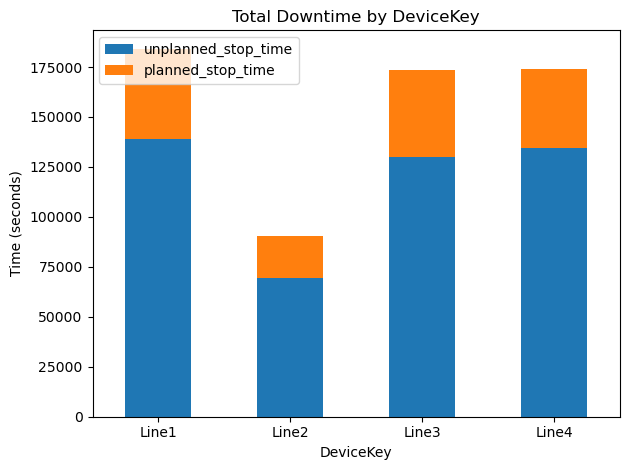

unplanned_stop_time                                                \
                          sum       mean median        std  min         max   
deviceKey                                                                     
Line1           139050.031367  51.576421    0.0  89.929091  0.0  640.208119   
Line2            69234.251328  49.172053    0.0  84.251790  0.0  809.164892   
Line3           130013.361104  41.300305    0.0  78.060467  0.0  439.728239   
Line4           134670.706773  49.006807    0.0  81.677030  0.0  468.443734   

          planned_stop_time                                           
                        sum       mean median        std  min    max  
deviceKey                                                             
Line1          45112.000000  16.732938    0.0  79.987160  0.0  951.0  
Line2          21230.000000  15.078125    0.0  74.095999  0.0  709.0  
Line3          43577.123462  13.842797    0.0  67.710112  0.0  612.0  
Line4          39556.000000  14.394469    0.0  70.585941  0.0  630.0

{'Unplanned': 0.7598575136578023, 'Planned': 0.24014248634219781}


In [8]:
downtime_summary = prod_metric.groupby('deviceKey')[['unplanned_stop_time', 'planned_stop_time']].agg(
    ['sum', 'mean', 'median', 'std', 'min', 'max']
)

total_unplanned = prod_metric['unplanned_stop_time'].sum()
total_planned = prod_metric['planned_stop_time'].sum()
total_downtime = total_unplanned + total_planned

downtime_proportions = {
    "Unplanned": total_unplanned / total_downtime,
    "Planned": total_planned / total_downtime
}

plt.figure(figsize=(14, 8))
downtime_stats = prod_metric.groupby('deviceKey')[['unplanned_stop_time', 'planned_stop_time']].sum().reset_index()
downtime_stats.set_index('deviceKey').plot(kind='bar', stacked=True)
plt.title("Total Downtime by DeviceKey")
plt.ylabel("Time (seconds)")
plt.xlabel("DeviceKey")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(downtime_summary)
print(downtime_proportions)

> About 76% of total downtime is due to unplanned stops, while only 24% is planned — indicating a significant area for process improvement.

## Unplanned stop Reasons

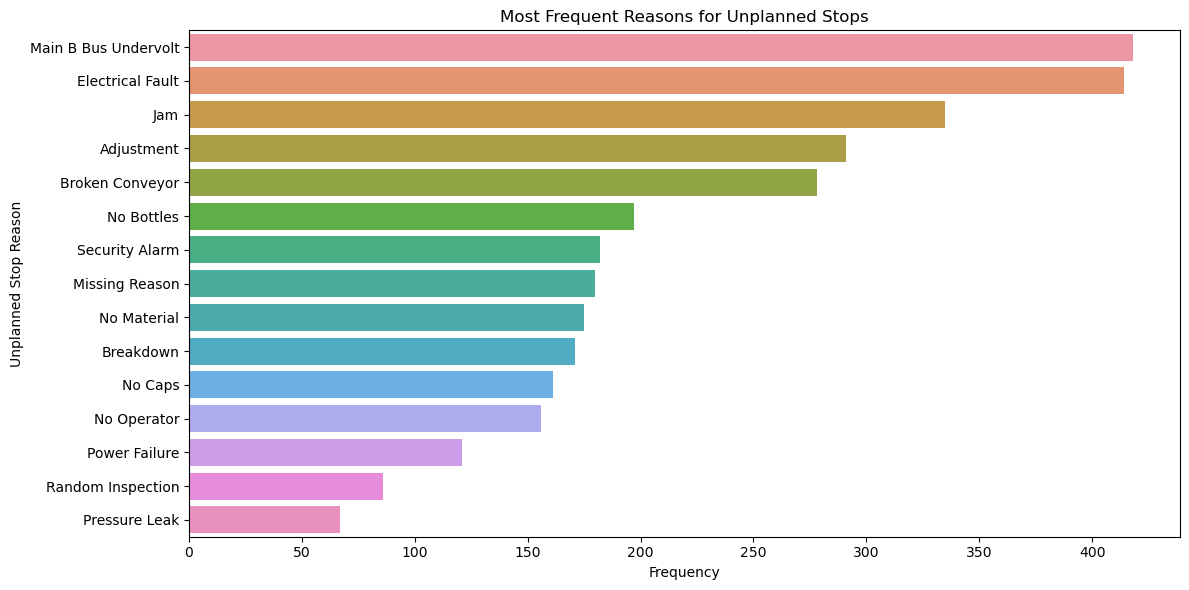

,Reason,Frequency
0,Main B Bus Undervolt,418
1,Electrical Fault,414
2,Jam,335
3,Adjustment,291
4,Broken Conveyor,278


In [9]:
unplanned_df = prod_metric[prod_metric['unplanned_stop_time'] > 0]

unplanned_reasons = unplanned_df['process_state_reason_display_name'].value_counts().reset_index()
unplanned_reasons.columns = ['Reason', 'Frequency']

plt.figure(figsize=(12, 6))
sns.barplot(data=unplanned_reasons, x='Frequency', y='Reason', order=unplanned_reasons['Reason'])
plt.title("Most Frequent Reasons for Unplanned Stops")
plt.xlabel("Frequency")
plt.ylabel("Unplanned Stop Reason")
plt.tight_layout()
plt.show()

unplanned_reasons.head()

> The most frequent cause of unplanned stops is "Main B Bus Undervolt", closely followed by "Electrical Fault" and "Jam" — all indicating potential hardware or electrical reliability issues.

# Production & Quality Analysis

## Most Common Reject Reasons

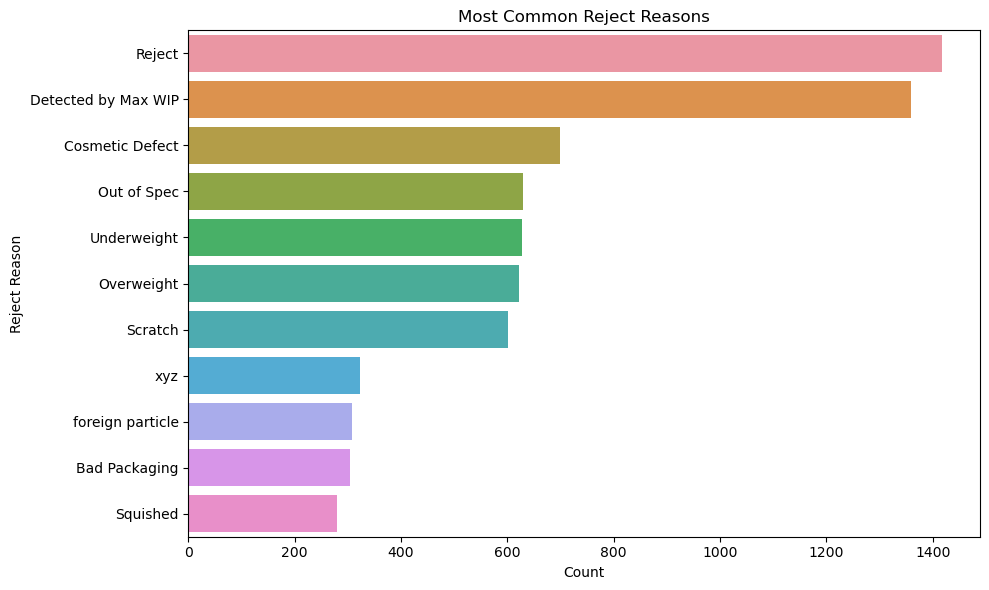

(0.03674795927494914,
          Reject Reason  Count
 0               Reject   1418
 1  Detected by Max WIP   1359
 2      Cosmetic Defect    699
 3          Out of Spec    630
 4          Underweight    627)

In [10]:
total_good = prod_metric['good_count'].sum()
total_reject = prod_metric['reject_count'].sum()
overall_reject_rate = total_reject / (total_good + total_reject)

reject_reasons = quality['reject_reason_display_name'].value_counts().reset_index()
reject_reasons.columns = ['Reject Reason', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=reject_reasons, y='Reject Reason', x='Count')
plt.title("Most Common Reject Reasons")
plt.xlabel("Count")
plt.ylabel("Reject Reason")
plt.tight_layout()
plt.show()

overall_reject_rate, reject_reasons.head()

> The overall reject rate is approximately 3.67%, with the top reject reasons being:

1. Reject

2. Detected by Max WIP

3. Cosmetic Defect

## Average good count per hour of runtime

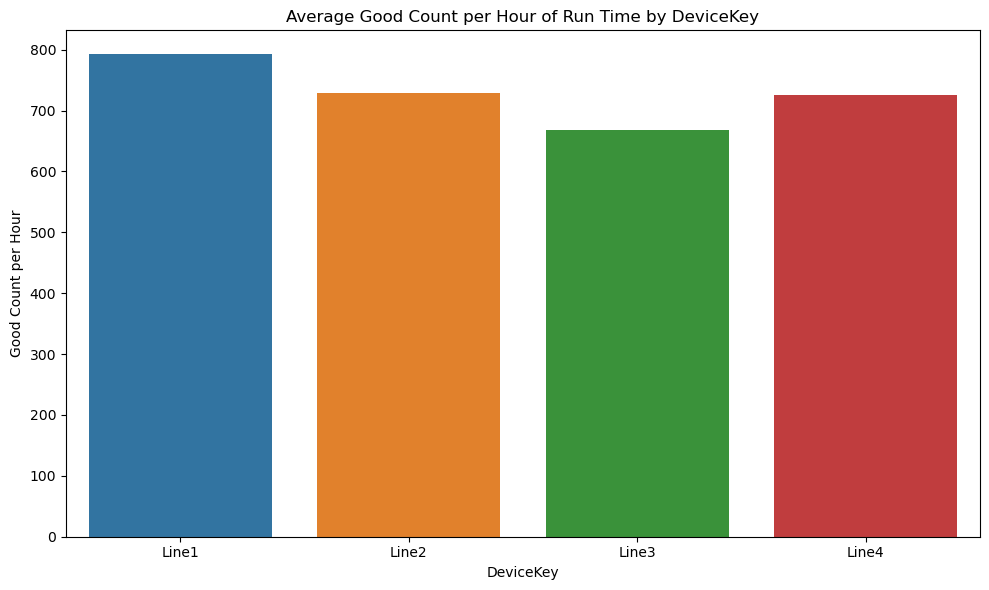

,deviceKey,good_per_hour
0,Line1,792.135860
1,Line2,729.186556
3,Line4,724.901137
2,Line3,667.988762


In [11]:
prod_metric['run_time_hours'] = prod_metric['run_time'] / 3600
prod_metric['good_per_hour'] = prod_metric.apply(
    lambda row: row['good_count'] / row['run_time_hours'] if row['run_time_hours'] > 0 else 0,
    axis=1
)

good_per_hour_stats = prod_metric.groupby('deviceKey')['good_per_hour'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=good_per_hour_stats, x='deviceKey', y='good_per_hour')
plt.title("Average Good Count per Hour of Run Time by DeviceKey")
plt.ylabel("Good Count per Hour")
plt.xlabel("DeviceKey")
plt.tight_layout()
plt.show()

good_per_hour_stats.sort_values(by='good_per_hour', ascending=False)

> Line1 has the highest production rate (~792 good items per hour), followed by Line2 and Line4, with Line3 having the lowest — suggesting potential throughput optimization opportunities on Line3.

## Correlation Between Unplanned Stop Time And Reject Count

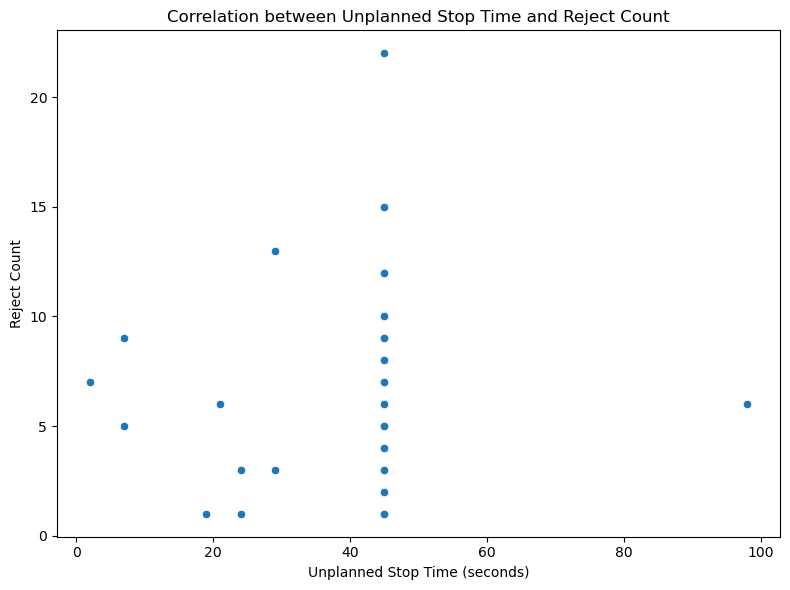

(0.014445453558728658, 0.9120173981926689)

In [12]:
corr_df = prod_metric[(prod_metric['unplanned_stop_time'] > 0) & (prod_metric['reject_count'] > 0)]

correlation, p_value = pearsonr(corr_df['unplanned_stop_time'], corr_df['reject_count'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=corr_df, x='unplanned_stop_time', y='reject_count')
plt.title("Correlation between Unplanned Stop Time and Reject Count")
plt.xlabel("Unplanned Stop Time (seconds)")
plt.ylabel("Reject Count")
plt.tight_layout()
plt.show()

correlation, p_value

> The correlation between unplanned stop time and reject count is essentially zero (r ≈ 0.014, p ≈ 0.91), indicating no significant linear relationship between the two — at least directly.

## Average Reject Rate By Shift

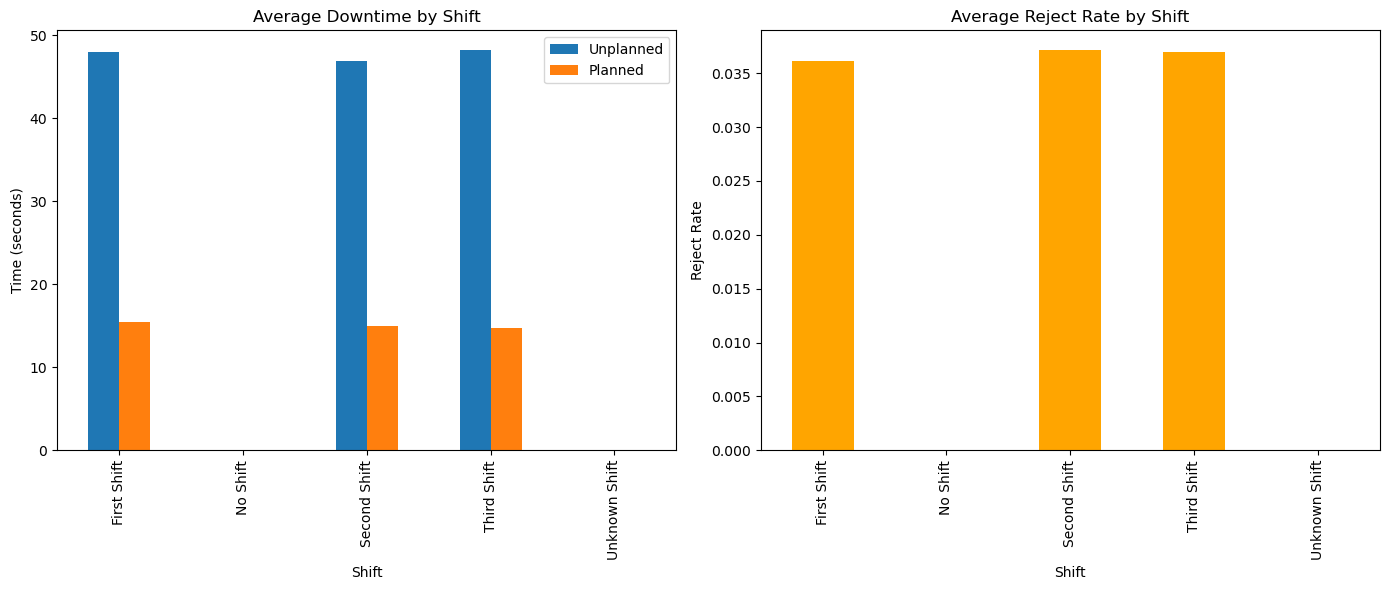

,shift_display_name,avg_unplanned_stop_time,avg_planned_stop_time,total_good,total_reject,reject_rate
0,First Shift,47.942943,15.496990,419277,15742,0.036187
1,No Shift,0.000000,0.000000,18,0,0.000000
2,Second Shift,46.887208,14.982764,427149,16473,0.037133
3,Third Shift,48.163150,14.683472,413042,15851,0.036958
4,Unknown Shift,0.000000,0.000000,439,0,0.000000


In [13]:
shift_summary = prod_metric.groupby('shift_display_name').agg(
    avg_unplanned_stop_time=('unplanned_stop_time', 'mean'),
    avg_planned_stop_time=('planned_stop_time', 'mean'),
    total_good=('good_count', 'sum'),
    total_reject=('reject_count', 'sum')
)

shift_summary['reject_rate'] = shift_summary['total_reject'] / (shift_summary['total_good'] + shift_summary['total_reject'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

shift_summary[['avg_unplanned_stop_time', 'avg_planned_stop_time']].plot(kind='bar', ax=axes[0])
axes[0].set_title("Average Downtime by Shift")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_xlabel("Shift")
axes[0].legend(["Unplanned", "Planned"])

shift_summary['reject_rate'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Average Reject Rate by Shift")
axes[1].set_ylabel("Reject Rate")
axes[1].set_xlabel("Shift")

plt.tight_layout()
plt.show()

shift_summary.reset_index()

> Here’s what we find from the shift-level performance comparison:

* All three active shifts (First, Second, Third) have very similar unplanned and planned downtime averages (~47–48s and ~14–15s respectively).

* Second Shift has the highest reject rate at 3.71%, followed closely by Third Shift and First Shift.